In [1]:
import sys
# sys.path.append('G:/My Drive/Research/adaptation_abm/code')
sys.path.append('/home/twilliams/adaptation_abm/code')
import model.model as mod
import plot.single_run as plt_single
import imp
import numpy as np
import pickle
imp.reload(mod)
imp.reload(plt_single)

<module 'plot.single_run' from '/home/twilliams/adaptation_abm/code/plot/single_run.py'>

In [18]:
f = '../../outputs/2019_10_15_4/POM/100000_10reps/input_params_0.pkl'
inputs = pickle.load(open(f, 'rb'))
inputs['adaptation']['burnin_period'] = 10

In [19]:
inputs['model']['seed'] = 0
inputs['model']['T'] = 100
# inputs['agents']['wealth_init_mean'] *=1
# inputs['land']['random_effect_sd'] = 0.5
inputs['model']['n_agents'] = 6


# inputs['land']['wealth_N_conversion'] *= 0.9
# inputs['land']['organic_N_min_init'] = 6000
# inputs['land']['organic_N_max_init'] = 6000
# inputs['agents']['cash_req_mean'] *= 1.3

# inputs['model']['adaptation_option'] = 'cover_crop'
# inputs['agents']['adap_type'] = 'always'

In [20]:
m = mod.Model(inputs)
for t in range(m.T):
    m.step()

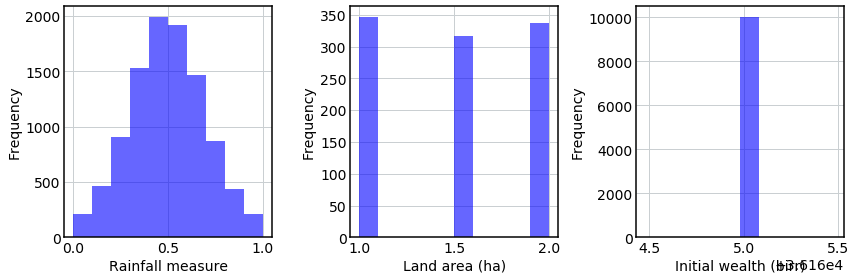

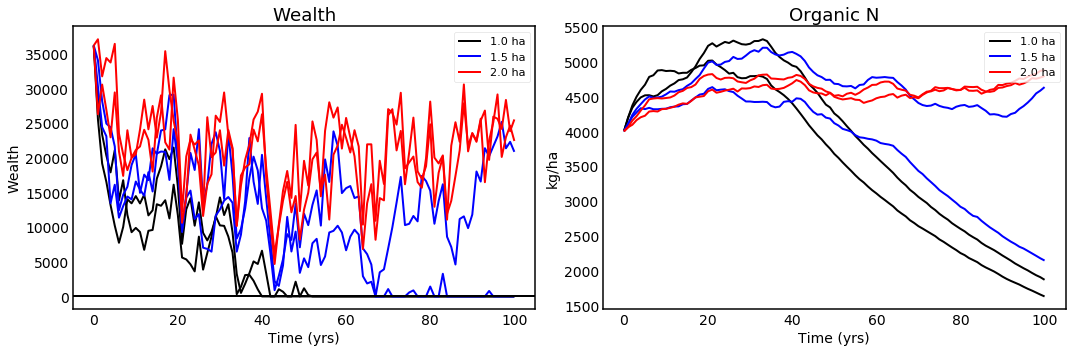

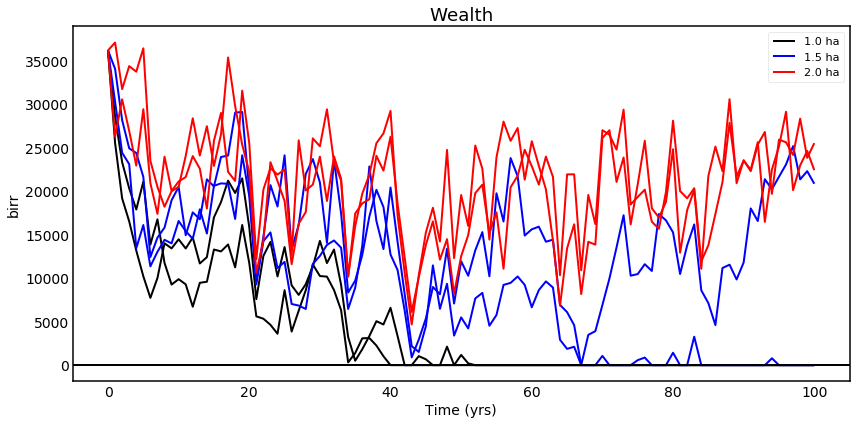

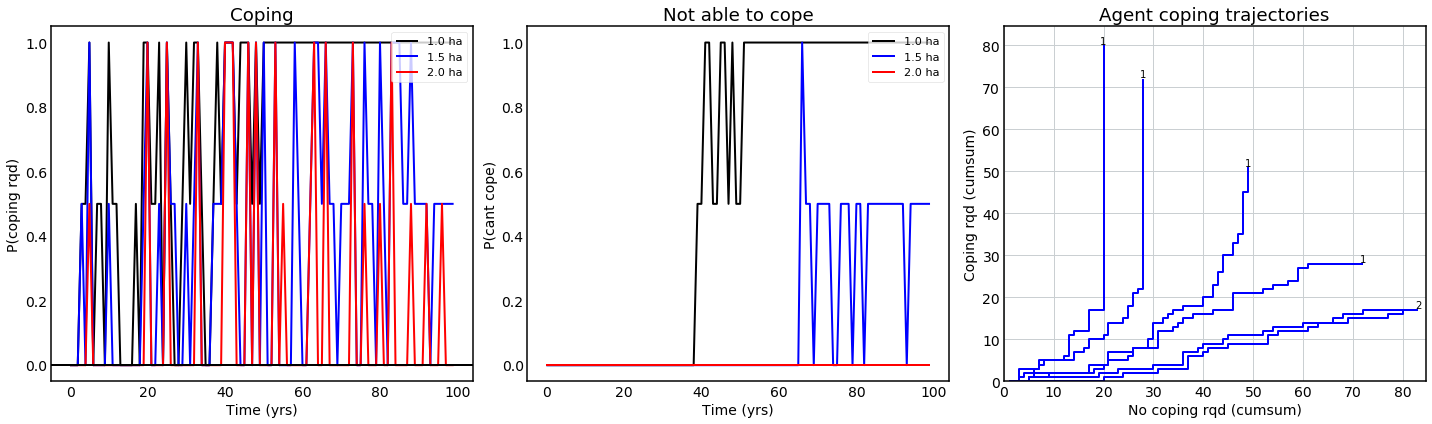

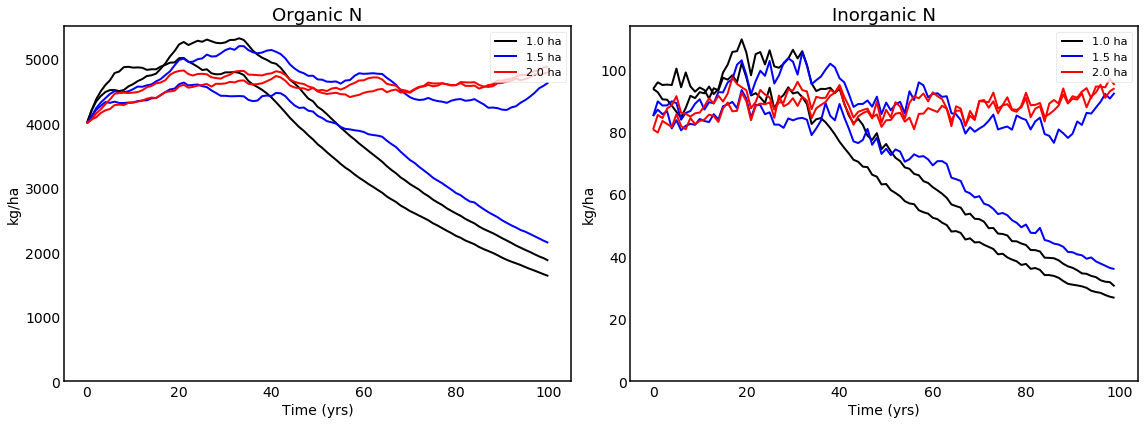

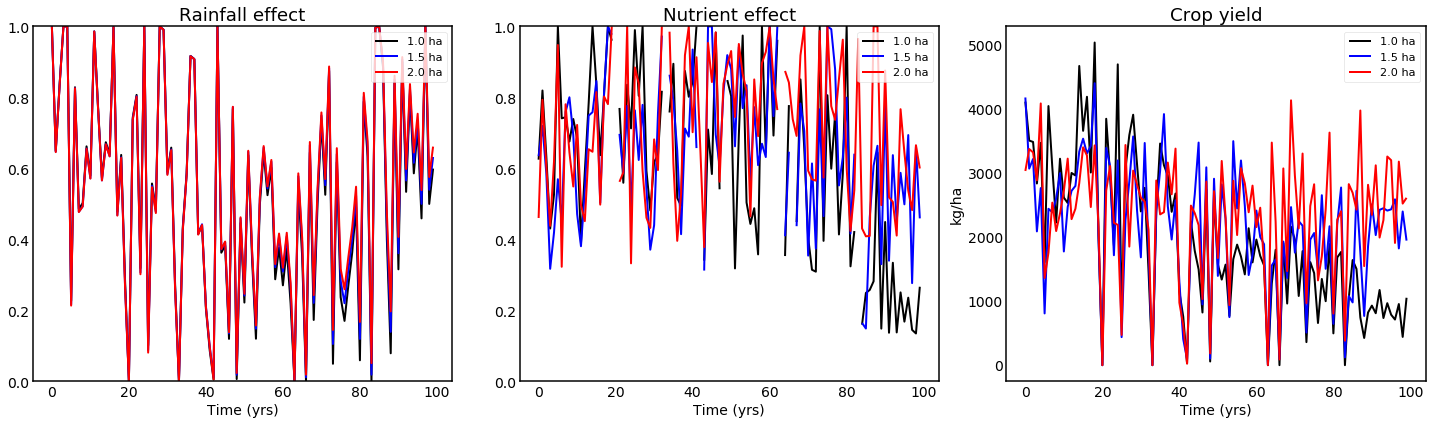

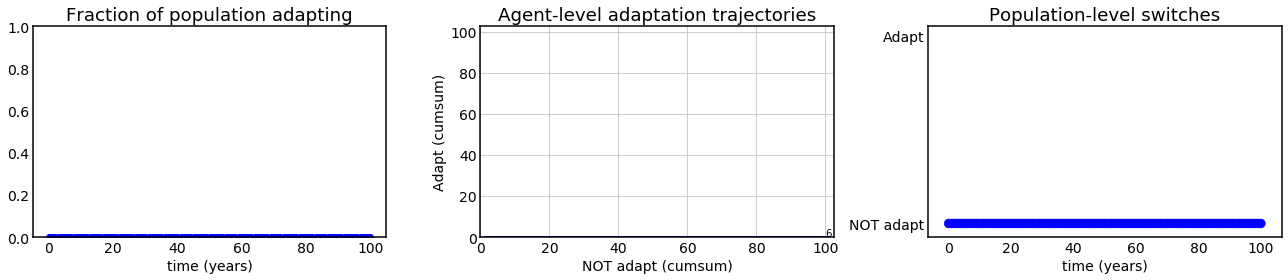

In [21]:
plt_single.main(m, save=False)